In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_core.messages import SystemMessage,HumanMessage,AIMessage

from pydantic import BaseModel,Field
from typing import List


from typing_extensions import TypedDict
from typing import Annotated
import operator

from langgraph.constants import Send

from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image,display


os.environ['GROQ_API_KEY']=os.getenv(key='GROQ_API_KEY')

from langchain_groq import ChatGroq
llm=ChatGroq(model='qwen-2.5-32b')
llm.invoke('Hello').content



'Hello! How can I assist you today?'

In [2]:


class Task(BaseModel):
    name:str=Field(description='Name of the task')
    description:str=Field(description='Description of the task')

class Tasks(BaseModel):
    tasks:List[Task]=Field(description='List of tasks')    

In [3]:

#graph state
class State(TypedDict):
    user_input:str
    tasks:List[Task]
    completed_tasks:Annotated[list,operator.add]
    final_plan:str

class WorkerState(TypedDict):
    task:Task
    completed_tasks:Annotated[list,operator.add]    

In [4]:


def planner(state: State):
    """Generates a plan for the tour."""
    # Safely retrieve user input
    user_input = state.get('user_input', '')

    # Configure the LLM to output in the Tasks structure
    planner_llm = llm.with_structured_output(Tasks)

    # Invoke the LLM with the system and human messages
    response = planner_llm.invoke([
        SystemMessage(content='Generate a plan based on the user input'),
        HumanMessage(content=f"Here is the user input: {user_input}")
    ])

    # Return the response containing the plan
    return {'tasks':response.tasks}


def worker(state:WorkerState):
    """Works on an assigned task and returns the completed task response."""
    task=state.get('task',None)
    # Invoke LLM to process the assigned task
    response = llm.invoke([
        SystemMessage(content="Provide the below task name and description and work accordingly."),
        HumanMessage(content=f"Here is the task name: {task.name} and description: {task.description}")
    ])

    return {'completed_tasks':[response.content]}


def synthesizer(state:State):
    """Combines all worker outputs into a final tour plan."""
    
    completed_tasks=state.get('completed_tasks')
    
     # Join completed tasks into a structured plan
    completed_task_plan = "\n\n---\n\n".join(completed_tasks) if completed_tasks else "No tasks completed."

    return {"final_plan": completed_task_plan}

def assign_workers(state:State):
    ''' Assign a task to each worker'''
    return [Send("Worker",{"task":s}) for s in state['tasks']]


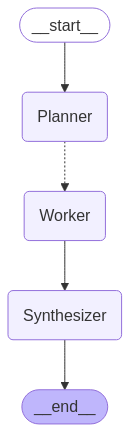

In [5]:


# Build the Workflow
builder=StateGraph(State)

# Define the nodes
builder.add_node("Planner",planner)
builder.add_node("Worker",worker)
builder.add_node('Synthesizer',synthesizer)


# Define the edges
builder.add_edge(START,"Planner")
builder.add_conditional_edges("Planner",assign_workers,["Worker"])
builder.add_edge("Worker","Synthesizer")
builder.add_edge("Synthesizer",END)


memory=MemorySaver()
planner=builder.compile(checkpointer=memory)

# view
display(Image(planner.get_graph().draw_mermaid_png()))



In [6]:
response = planner.invoke(
    input={'user_input': 'Plan a trip for Italy from Chennai for 5 days from 22March2025 to 27March2025'},
    config={'configurable': {'thread_id': '1'}}
)

In [7]:
from IPython.display import Markdown
Markdown(response['final_plan'])

### Task Name: Flight Booking

### Description:
Book flights from Chennai to Italy for the period from March 22, 2025, to March 27, 2025.

### Work Plan:

1. **Identify Airlines and Travel Agencies:**
   - Research airlines that offer direct or connecting flights from Chennai to Italy.
   - Consider popular airlines like Emirates, Qatar Airways, Lufthansa, and Air India.

2. **Check Flight Availability:**
   - Use travel booking websites such as Skyscanner, Expedia, or Google Flights to check flight availability.
   - Ensure the departure date is March 22, 2025, and the return date is March 27, 2025.

3. **Compare Prices and Itineraries:**
   - Compare the prices and flight durations for different airlines.
   - Evaluate the layover times and airport connections for connecting flights.

4. **Consider Additional Preferences:**
   - Check for any preferred flight times (e.g., morning, evening).
   - Look into any special services or amenities offered by the airlines.

5. **Book the Flight:**
   - Select the most suitable flight based on the above criteria.
   - Proceed to the booking process and ensure all personal information is correct.
   - Complete the payment process using a secure and reliable payment method.

6. **Confirmation and Documentation:**
   - Obtain and save the booking confirmation email and any other relevant documentation.
   - Verify the details (flight numbers, departure and arrival times, etc.) are correct.

7. **Notify Relevant Parties:**
   - Inform the traveler(s) of the flight details and any necessary travel documents (passport, visa, etc.).
   - Provide them with the booking confirmation and any other relevant information.

### Example Booking Details:
- **Departure:**
  - From: Chennai (MAA)
  - To: Rome (FCO)
  - Date: March 22, 2025
  - Time: E.g., 10:00 AM
  - Duration: E.g., 11 hours (including layovers)

- **Return:**
  - From: Rome (FCO)
  - To: Chennai (MAA)
  - Date: March 27, 2025
  - Time: E.g., 2:00 PM
  - Duration: E.g., 10 hours (including layovers)

By following this work plan, you can efficiently book the required flights from Chennai to Italy for the specified dates.

---

### Task Name: Hotel Reservation in Italy

### Description:
Book a hotel in Italy for a 5-night stay from March 22, 2025, to March 27, 2025.

### Steps to Complete the Task:

1. **Determine the Location:**
   - Decide which city or region in Italy is preferred for the stay (e.g., Rome, Florence, Venice, etc.).

2. **Choose a Booking Platform:**
   - Select a reliable online booking platform such as Booking.com, Expedia, Airbnb, or directly through the hotel's website.

3. **Search for Available Hotels:**
   - Use the chosen platform to search for hotels within the specified dates (March 22, 2025, to March 27, 2025).
   - Filter the search by location, price range, and amenities (e.g., free Wi-Fi, breakfast, parking, etc.).

4. **Review Hotel Details:**
   - Read reviews and check ratings of the hotels that match the criteria.
   - Look at photos and descriptions to get a better idea of the hotel's atmosphere and facilities.

5. **Make the Booking:**
   - Once a suitable hotel is found, proceed to make the reservation.
   - Follow the booking process, ensuring all details such as check-in/check-out times, number of guests, and any special requests are correct.

6. **Confirm the Booking:**
   - After booking, check the confirmation email for all details of the reservation.
   - Keep the booking confirmation handy for any future reference or changes.

7. **Additional Considerations:**
   - Check for any additional fees or cancellation policies.
   - Note down emergency contact information for the hotel.

### Example Booking Information:

- **Dates:** March 22, 2025, to March 27, 2025 (5 nights)
- **Location:** Florence, Italy
- **Platform:** Booking.com
- **Preferred Amenities:** Free Wi-Fi, breakfast included, close to city center

By following these steps, you can ensure that you successfully book a hotel in Italy for the specified dates.

---

### Task Name: Itinerary Planning

### Task Description:
Plan an itinerary for sightseeing, dining, and other activities for a 5-day trip to Italy. The itinerary should include a mix of cultural experiences, dining at local restaurants, and leisure activities. Ensure the itinerary is feasible and enjoyable for travelers with a variety of interests.

### Day 1: Arrival in Rome
- **Morning:**
  - Arrive in Rome, transfer to hotel.
  - Check-in and freshen up.
- **Afternoon:**
  - Visit the Colosseum and Roman Forum.
  - Continue to Palatine Hill for panoramic views of the city.
- **Evening:**
  - Dinner at a traditional Roman trattoria, enjoy local dishes like Carbonara or Cacio e Pepe.
  - Stroll around the historic center.

### Day 2: Rome
- **Morning:**
  - Visit the Pantheon.
  - Walk through Piazza Navona and admire the Baroque architecture.
- **Afternoon:**
  - Explore the Vatican Museums and Sistine Chapel.
- **Evening:**
  - Dinner at a cozy Italian restaurant in Trastevere.
  - Enjoy the nightlife in Trastevere.

### Day 3: Day Trip to Tivoli
- **Morning:**
  - Early bus or taxi to Tivoli.
  - Visit Hadrian’s Villa.
- **Afternoon:**
  - Explore the Villa d'Este, famous for its fountains and gardens.
- **Evening:**
  - Return to Rome.
  - Dinner at a local pizzeria in the city center.

### Day 4: Florence
- **Morning:**
  - Morning flight or train to Florence.
  - Check-in at hotel and take a walk around Piazza della Signoria.
- **Afternoon:**
  - Visit the Uffizi Gallery.
  - Explore Santa Croce Basilica and the Duomo.
- **Evening:**
  - Dinner at a Tuscan restaurant, trying local specialties like Bistecca alla Fiorentina.

### Day 5: Venice
- **Morning:**
  - Morning train to Venice.
  - Check-in at hotel and take a gondola ride through the canals.
- **Afternoon:**
  - Visit St. Mark’s Basilica and the Doge’s Palace.
- **Evening:**
  - Dinner at a seafood restaurant in the Rialto area.
  - Final evening stroll through the historic center of Venice.

### Notes:
- Ensure to book flights or trains in advance.
- Reserve tickets for popular attractions to skip lines.
- Try to book dinner reservations in advance, especially for weekends.
- Wear comfortable shoes as there will be a lot of walking.
- Enjoy the local wine and cuisine.